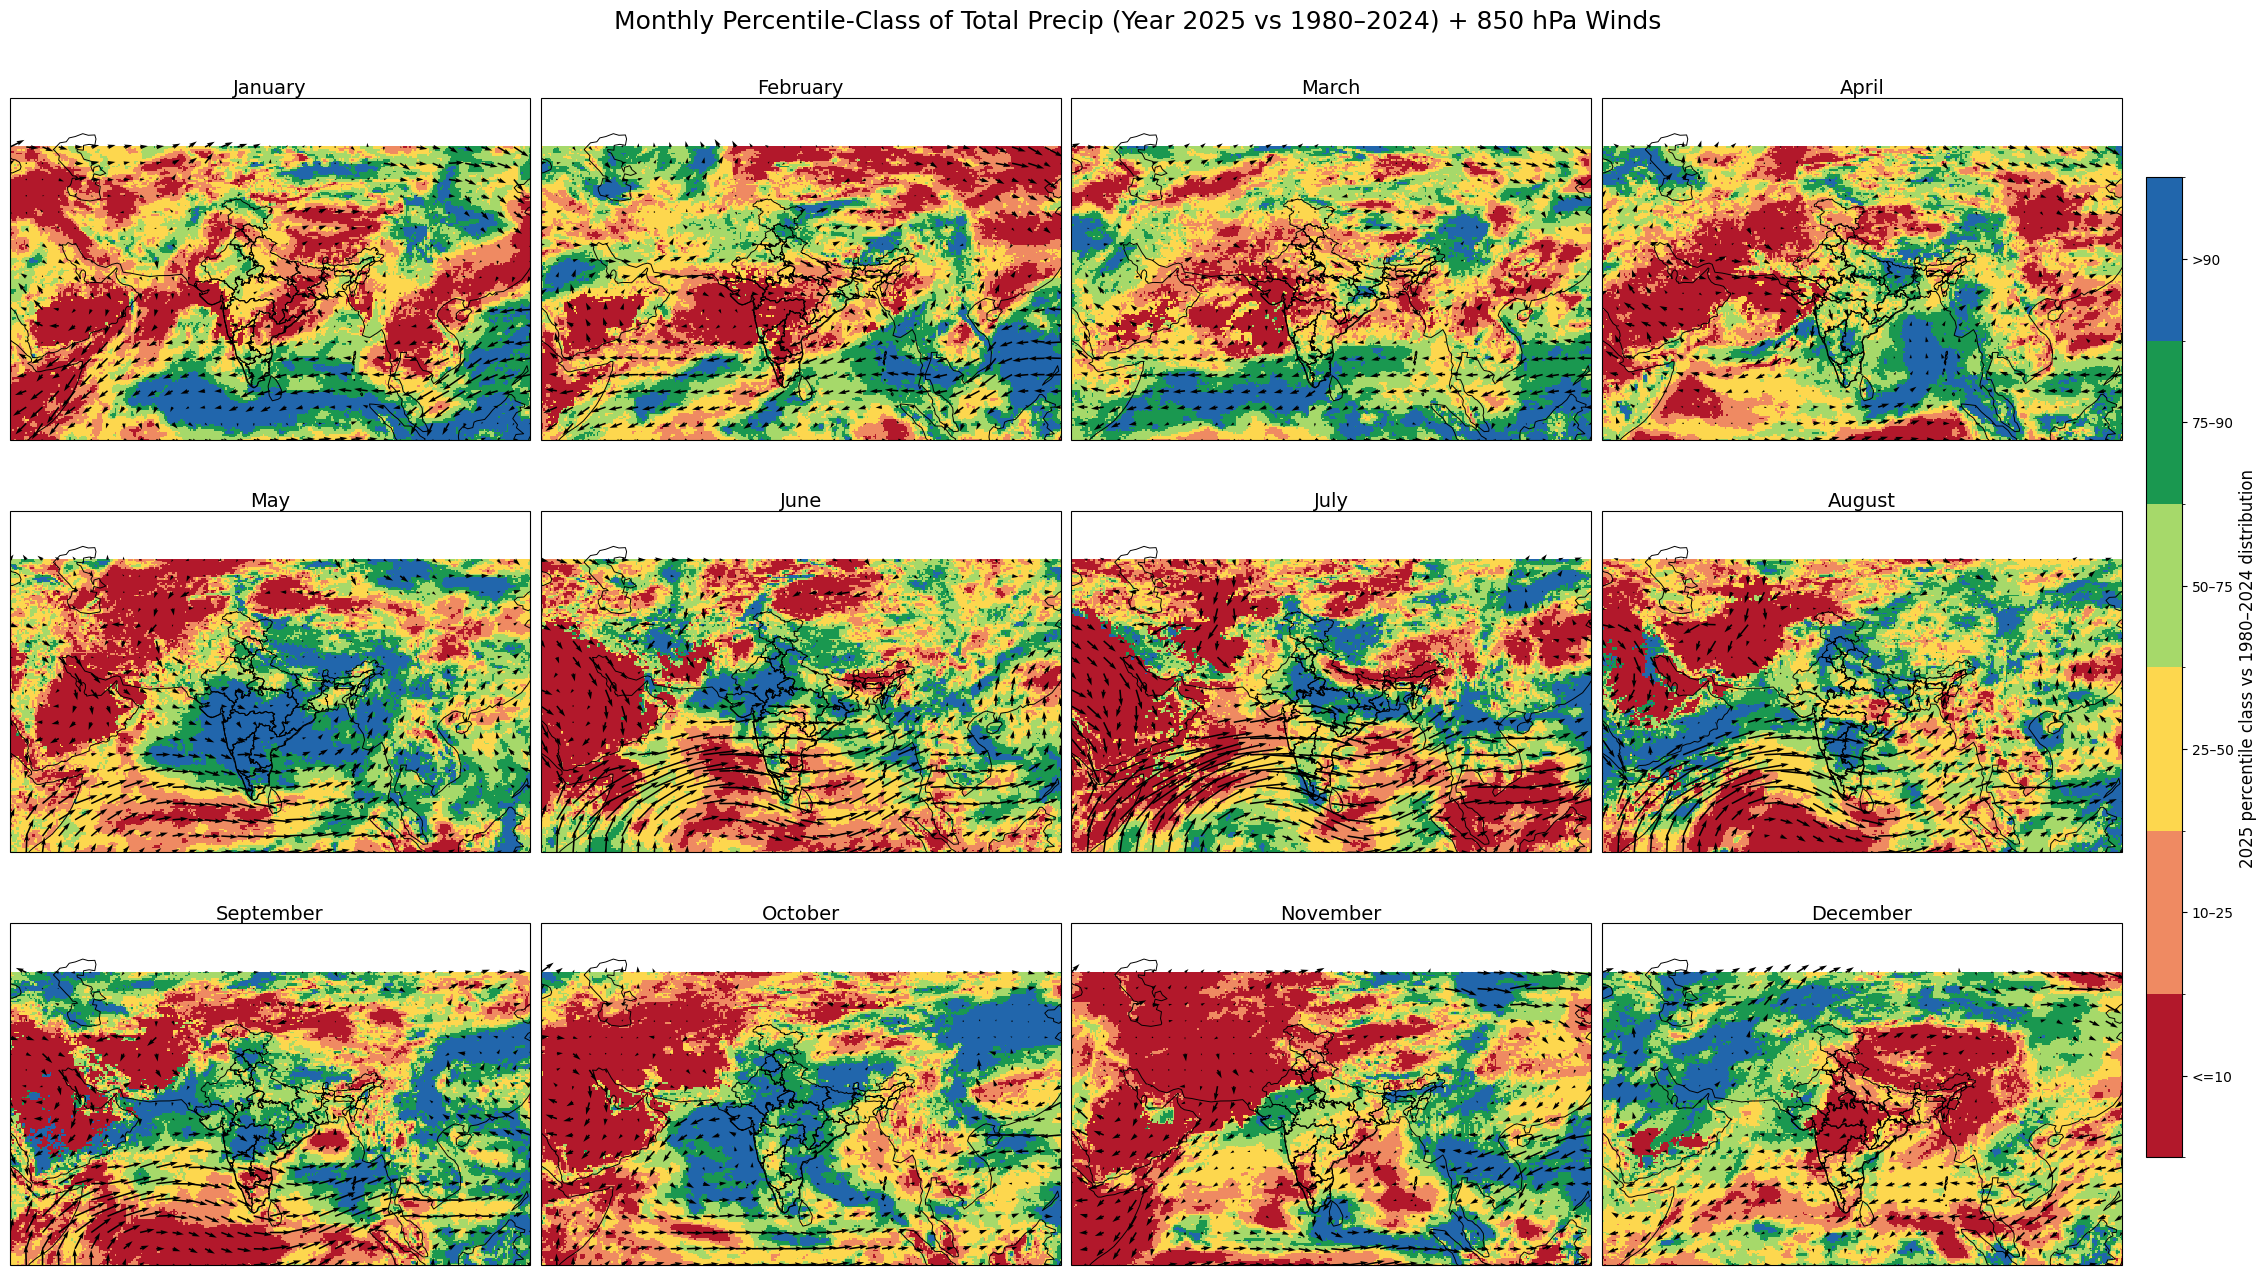

In [1]:
# ============================================================
# 2025 PERCENTILE-CLASS COMPOSITE (3x4):
#  - background: percentile-class of 2025 monthly TP vs 1980–2024 distribution
#  - optional: 2025 winds (u,v)
#  - optional: WD tracks from a different YEAR_WD
#
# Classes: <=10, 10–25, 25–50, 50–75, 75–90, >90
# Color scheme: red->orange->yellow->green->blue (driest->wettest)
# ============================================================

import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# ----------------------------
# USER CONTROLS
# ----------------------------
YEAR_MET = 2025
YEAR_WD  = 2019

PLOT_WIND = True
PLOT_WD   = False

# --- precipitation dirs ---
clim_dist_dir = r"/media/nilay/HDD/IIT KGP 2025/PHD/ERA5_Downloads/TP_SF_T2M_1980-2024"
yr_dir        = r"/media/nilay/HDD/IIT KGP 2025/PHD/ERA5_Downloads/TP_SF_T2M_2025"

# --- wind dirs (monthly u/v) ---
wind_dir = r"/home/nilay/SSD Data Downloads/ERA5 Wind 2025"
wind_prefix = "UVPL_u_v"
WIND_LEVEL_HPA = 850.0

# --- shapefile ---
india_shp = r"/media/nilay/HDD/IIT KGP 2025/PHD/Shapefiles/India Shapefile With Kashmir/India Shape/india_st.shp"

# --- WD catalogue (only if PLOT_WD=True) ---
wd_catalogue_csv = r"/media/nilay/HDD/IIT KGP 2025/PHD/wd_era5_T42_42p5N.csv"
wd_time_dayfirst = True

# --- REGION (set ONCE; used everywhere) ---
REGION = dict(lon_min=40, lon_max=120, lat_min=0, lat_max=45)

# WD "must pass through" box (only if PLOT_WD=True)
BOX_EXTENT = [70, 82, 28, 36]

# Variables
precip_var = "tp"  # meters -> mm

# WD controls
LON_0_360_WD = False
VORT_MIN = None
MAX_TRACKS_PER_MONTH = 20
TRACK_LINEWIDTH = 1.0
TRACK_ALPHA = 0.95
DRAW_START_END = False

# Wind quiver controls
QUIVER_SKIP  = 10
QUIVER_SCALE = 250
QUIVER_WIDTH = 0.003

# Plot layout controls
FIGSIZE = (24, 14)
WSPACE = 0.02
HSPACE = 0.09
LEFT, RIGHT, BOTTOM, TOP = 0.03, 0.91, 0.06, 0.92

months = [
    "January", "February", "March", "April",
    "May", "June", "July", "August",
    "September", "October", "November", "December"
]

# ============================================================
# HELPERS: lon/lat conversion + region subset (used everywhere)
# ============================================================
def to_lon180(da, lon_name="longitude"):
    lon = da[lon_name]
    lon180 = ((lon + 180) % 360) - 180
    return da.assign_coords({lon_name: lon180}).sortby(lon_name)

def subset_region_da(da, region):
    da = to_lon180(da, "longitude")

    lat = da["latitude"]
    if lat[0] > lat[-1]:  # descending
        da = da.sel(latitude=slice(region["lat_max"], region["lat_min"]))
    else:                 # ascending
        da = da.sel(latitude=slice(region["lat_min"], region["lat_max"]))

    da = da.sel(longitude=slice(region["lon_min"], region["lon_max"]))
    return da

def time_dim_name(ds):
    for cand in ["valid_time", "time"]:
        if cand in ds.dims:
            return cand
    return None

def load_clim_stack_for_month(mon_name: str):
    clim_file = os.path.join(
        clim_dist_dir,
        f"TP_SF_T2M_{mon_name}_19802024_data_stream-moda_stepType-avgad.nc"
    )
    if not os.path.exists(clim_file):
        raise FileNotFoundError(f"Climatology file not found: {clim_file}")

    ds = xr.open_dataset(clim_file)
    tdim = time_dim_name(ds)
    if tdim is None or ds[tdim].size < 5:
        raise ValueError(f"Climatology file must have multiple time samples: {clim_file}")

    tp = ds[precip_var] * 1000.0
    tp = subset_region_da(tp, REGION)
    return tp.rename({tdim: "sample"})  # (sample, lat, lon)

def load_year_month_tp(mon_name: str):
    yr_file = os.path.join(
        yr_dir,
        f"TP_SF_T2M_{mon_name}_{YEAR_MET}{YEAR_MET}_data_stream-moda_stepType-avgad.nc"
    )
    if not os.path.exists(yr_file):
        raise FileNotFoundError(f"Year file not found: {yr_file}")

    ds = xr.open_dataset(yr_file)
    tdim = time_dim_name(ds)

    tp = ds[precip_var]
    if tdim is not None and tp[tdim].size > 1:
        tp = tp.mean(tdim)
    elif tdim is not None and tp[tdim].size == 1:
        tp = tp.isel({tdim: 0})

    tp = tp * 1000.0
    tp = subset_region_da(tp, REGION)
    return tp  # (lat, lon)

def load_uv_for_month(mon_name: str):
    wfile = os.path.join(wind_dir, f"{wind_prefix}_{mon_name}_{YEAR_MET}{YEAR_MET}.nc")
    if not os.path.exists(wfile):
        return None, None

    dsw = xr.open_dataset(wfile)
    u = dsw["u"].sel(pressure_level=WIND_LEVEL_HPA).isel(valid_time=0)
    v = dsw["v"].sel(pressure_level=WIND_LEVEL_HPA).isel(valid_time=0)

    u = subset_region_da(u, REGION)
    v = subset_region_da(v, REGION)
    return u, v

def percentile_rank_map(clim_stack, val_year):
    # fraction of clim samples < 2025 value
    return (clim_stack < val_year).mean("sample") * 100.0

# ============================================================
# OPTIONAL WD LOADER
# ============================================================
wd_y_box = None
tracks_in_box_year = np.array([], dtype=int)

if PLOT_WD:
    wd = pd.read_csv(wd_catalogue_csv)
    wd["time"] = pd.to_datetime(wd["time"], dayfirst=wd_time_dayfirst, errors="coerce")
    wd = wd.dropna(subset=["time", "lon", "lat", "track_id"]).copy()

    if LON_0_360_WD:
        wd["lon"] = (wd["lon"] + 180) % 360 - 180

    if VORT_MIN is not None and "vort" in wd.columns:
        wd = wd[wd["vort"] >= VORT_MIN].copy()

    wd["year"] = wd["time"].dt.year
    wd["month"] = wd["time"].dt.month
    wd_y = wd[wd["year"] == YEAR_WD].sort_values(["track_id", "time"]).copy()

    bLON_MIN, bLON_MAX, bLAT_MIN, bLAT_MAX = BOX_EXTENT
    in_box = (
        wd_y["lon"].between(bLON_MIN, bLON_MAX) &
        wd_y["lat"].between(bLAT_MIN, bLAT_MAX)
    )
    tracks_in_box_year = wd_y.loc[in_box, "track_id"].unique()
    wd_y_box = wd_y[wd_y["track_id"].isin(tracks_in_box_year)].copy()

    box_lons = [bLON_MIN, bLON_MAX, bLON_MAX, bLON_MIN, bLON_MIN]
    box_lats = [bLAT_MIN, bLAT_MIN, bLAT_MAX, bLAT_MAX, bLAT_MIN]

# ============================================================
# SHAPEFILE
# ============================================================
reader = shpreader.Reader(india_shp)
india_geom = list(reader.geometries())

# ============================================================
# CLASS COLORS
# ============================================================
bins = np.array([0, 10, 25, 50, 75, 90, 100], dtype=float)
labels = ["<=10", "10–25", "25–50", "50–75", "75–90", ">90"]

colors = ["#b2182b", "#ef8a62", "#fdd74e", "#a6d96a", "#1a9850", "#2166ac"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bins, cmap.N)

# ============================================================
# FIGURE: 3x4
# ============================================================
fig, axes = plt.subplots(
    3, 4, figsize=FIGSIZE,
    subplot_kw={"projection": ccrs.PlateCarree()}
)
axes = axes.flatten()

im = None  # store last mappable for colorbar

for i, mon in enumerate(months, start=1):
    ax = axes[i - 1]

    clim_stack = load_clim_stack_for_month(mon)
    tp_year    = load_year_month_tp(mon)

    pct_rank = percentile_rank_map(clim_stack, tp_year)

    im = ax.pcolormesh(
        pct_rank.longitude, pct_rank.latitude, pct_rank,
        cmap=cmap, norm=norm, shading="auto",
        transform=ccrs.PlateCarree()
    )

    # WIND overlay
    if PLOT_WIND:
        u, v = load_uv_for_month(mon)
        if u is not None and v is not None:
            u2 = u[::QUIVER_SKIP, ::QUIVER_SKIP]
            v2 = v[::QUIVER_SKIP, ::QUIVER_SKIP]
            ax.quiver(
                u2.longitude, u2.latitude,
                u2.values, v2.values,
                transform=ccrs.PlateCarree(),
                scale=QUIVER_SCALE,
                width=QUIVER_WIDTH,
                zorder=5
            )

    # Base layers
    ax.coastlines(resolution="110m", linewidth=0.7)
    ax.add_geometries(india_geom, crs=ccrs.PlateCarree(),
                      facecolor="none", edgecolor="black", linewidth=0.7)

    # WD overlay
    if PLOT_WD and wd_y_box is not None and len(wd_y_box) > 0:
        ax.plot(box_lons, box_lats, transform=ccrs.PlateCarree(), linewidth=1.0, zorder=6)

        entered_this_month = (
            (wd_y_box["month"] == i) &
            (wd_y_box["lon"].between(bLON_MIN, bLON_MAX)) &
            (wd_y_box["lat"].between(bLAT_MIN, bLAT_MAX))
        )
        month_track_ids = wd_y_box.loc[entered_this_month, "track_id"].unique()

        if MAX_TRACKS_PER_MONTH is not None and len(month_track_ids) > MAX_TRACKS_PER_MONTH:
            sizes = wd_y_box[wd_y_box["track_id"].isin(month_track_ids)].groupby("track_id").size()
            month_track_ids = sizes.sort_values(ascending=False).head(MAX_TRACKS_PER_MONTH).index.values

        for tid in month_track_ids:
            tr = wd_y_box[wd_y_box["track_id"] == tid].sort_values("time")
            ax.plot(tr["lon"].values, tr["lat"].values,
                    transform=ccrs.PlateCarree(),
                    linewidth=TRACK_LINEWIDTH, alpha=TRACK_ALPHA, zorder=7)

    # One extent everywhere
    ax.set_extent([REGION["lon_min"], REGION["lon_max"], REGION["lat_min"], REGION["lat_max"]])

    ax.set_title(mon, fontsize=14, pad=2)
    ax.set_xticks([]); ax.set_yticks([])

# ----------------------------
# COLORBAR (shared, categorical)
# ----------------------------
if im is not None:
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cb = fig.colorbar(im, cax=cax)

    mids = (bins[:-1] + bins[1:]) / 2.0
    cb.set_ticks(mids)
    cb.set_ticklabels(labels)
    cb.set_label("2025 percentile class vs 1980–2024 distribution", fontsize=12)

# ----------------------------
# TITLE + LAYOUT
# ----------------------------
title = f"Monthly Percentile-Class of Total Precip (Year {YEAR_MET} vs 1980–2024)"
if PLOT_WIND:
    title += f" + {int(WIND_LEVEL_HPA)} hPa Winds"
if PLOT_WD:
    title += f" + WD({YEAR_WD})"

fig.suptitle(title, fontsize=18, y=0.97, x=0.50)

plt.subplots_adjust(
    left=LEFT, right=RIGHT,
    bottom=BOTTOM, top=TOP,
    wspace=WSPACE, hspace=HSPACE
)

plt.show()

# Optional WD counts
if PLOT_WD and wd_y_box is not None:
    print(f"\nWD YEAR = {YEAR_WD}")
    print(f"Unique WD tracks that passed through BOX at least once in {YEAR_WD}: {len(tracks_in_box_year)}")
    print(f"BOX = {BOX_EXTENT}")


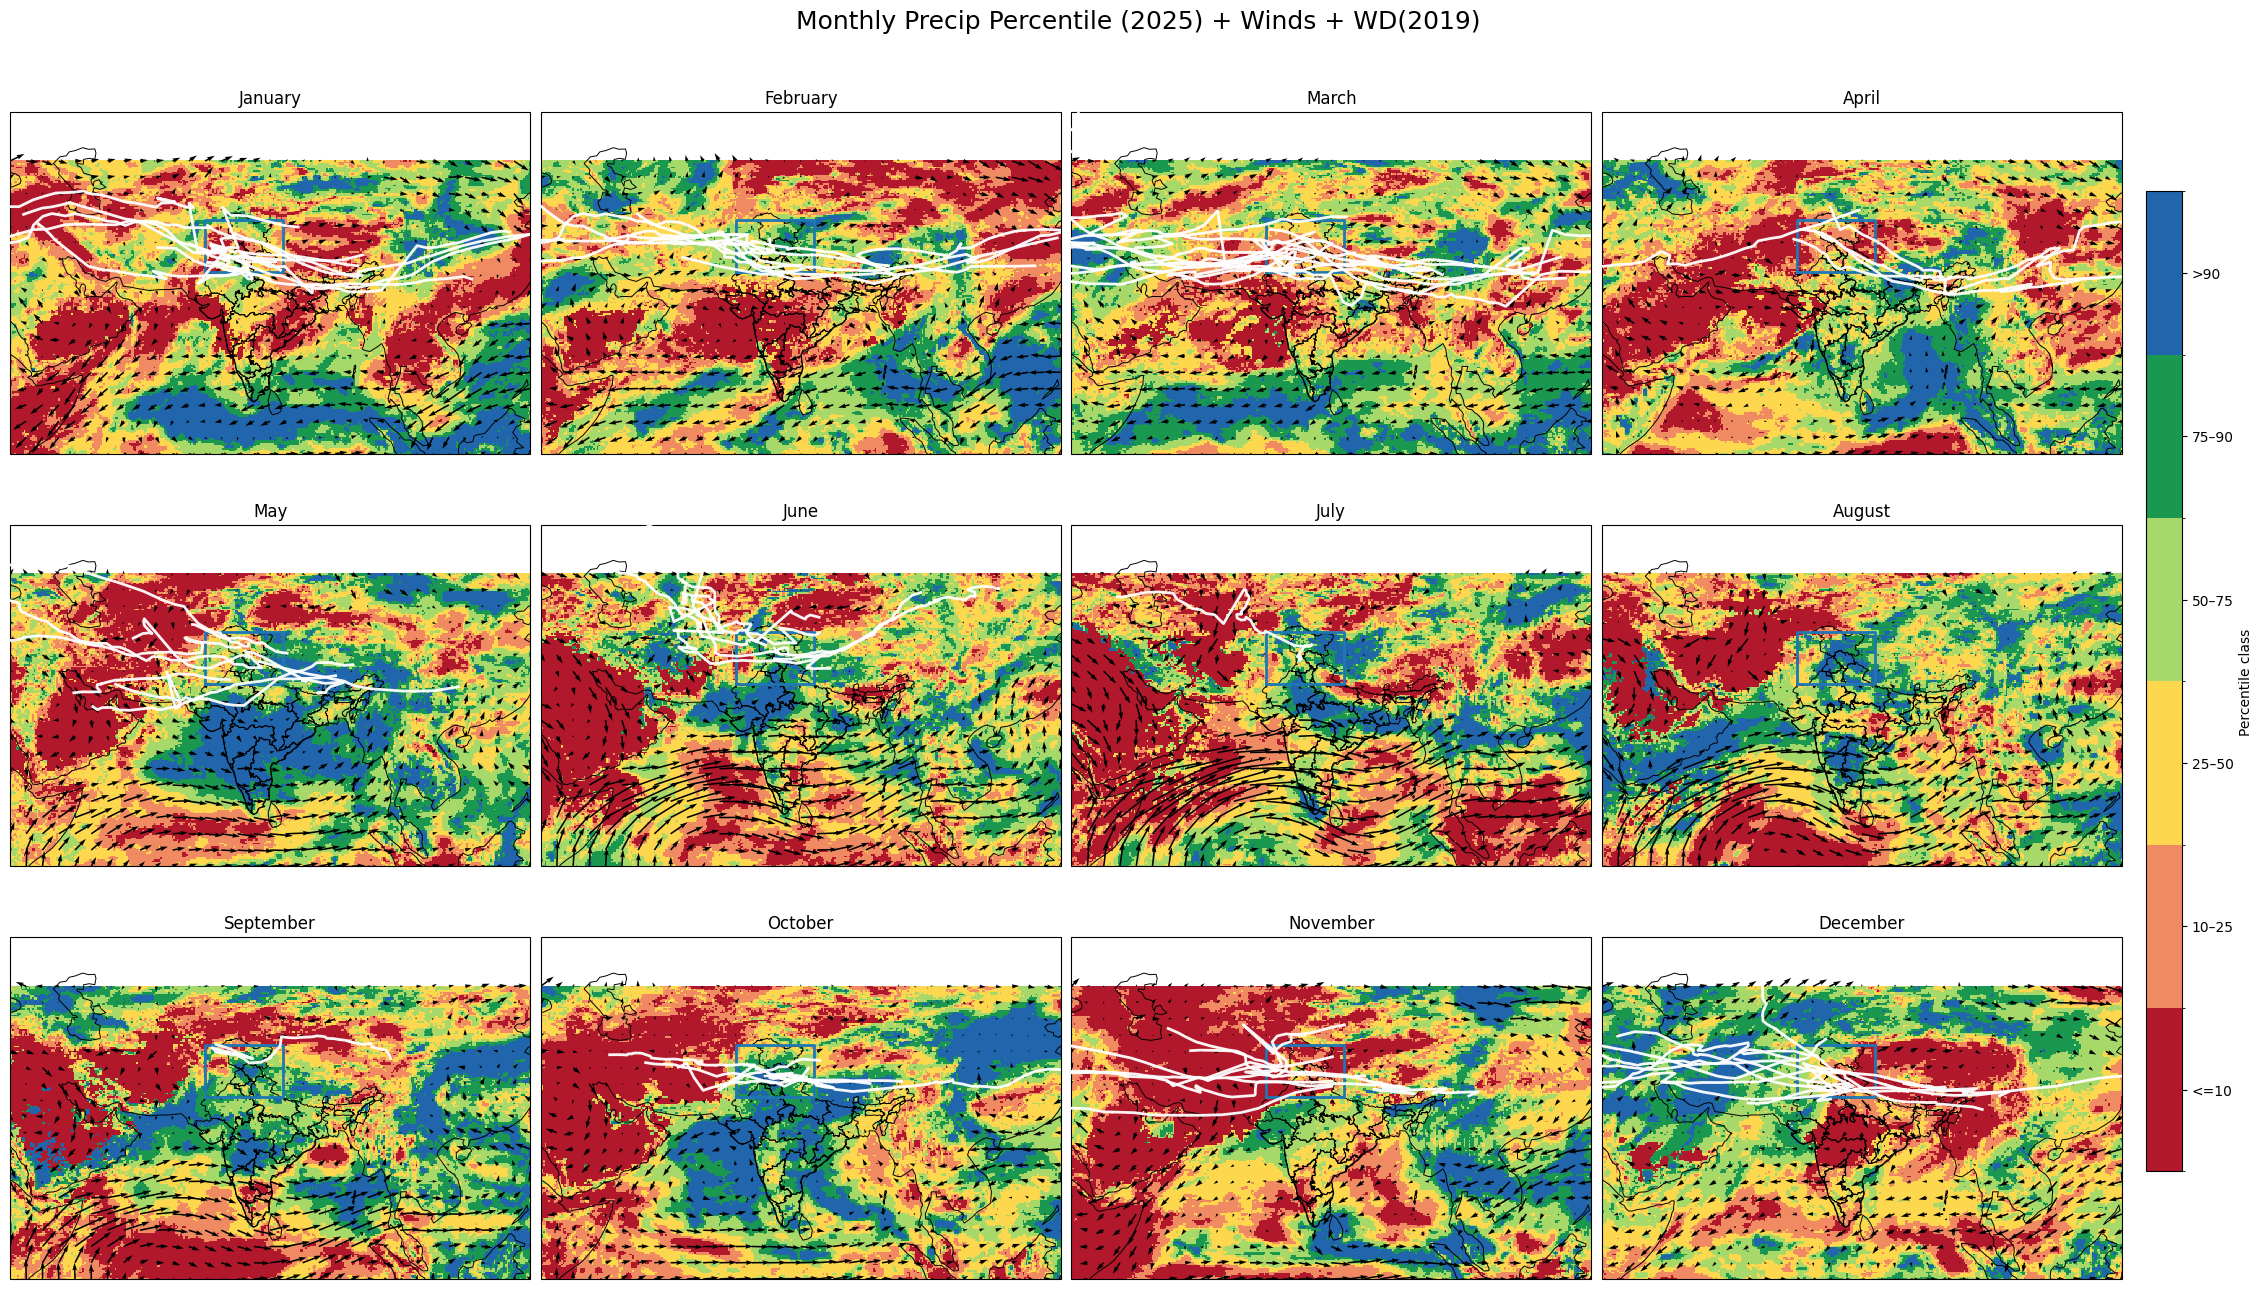


WD YEAR = 2019
Total unique WD tracks: 79
BOX = [70, 82, 28, 36]

Jan: 12 tracks
Feb: 9 tracks
Mar: 14 tracks
Apr: 5 tracks
May: 9 tracks
Jun: 7 tracks
Jul: 1 tracks
Aug: 0 tracks
Sep: 1 tracks
Oct: 6 tracks
Nov: 8 tracks
Dec: 10 tracks


In [6]:
# ============================================================
# 2025 PERCENTILE-CLASS COMPOSITE (3x4)
# + OPTIONAL WD TRACK OVERLAY + MONTHLY WD COUNTS
# ============================================================

import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# ----------------------------
# USER CONTROLS
# ----------------------------
YEAR_MET = 2025
YEAR_WD  = 2019

PLOT_WIND = True
PLOT_WD   = True   # <<< MASTER WD SWITCH

clim_dist_dir = r"/media/nilay/HDD/IIT KGP 2025/PHD/ERA5_Downloads/TP_SF_T2M_1980-2024"
yr_dir        = r"/media/nilay/HDD/IIT KGP 2025/PHD/ERA5_Downloads/TP_SF_T2M_2025"

wind_dir = r"/home/nilay/SSD Data Downloads/ERA5 Wind 2025"
wind_prefix = "UVPL_u_v"
WIND_LEVEL_HPA = 850.0

india_shp = r"/media/nilay/HDD/IIT KGP 2025/PHD/Shapefiles/India Shapefile With Kashmir/India Shape/india_st.shp"

wd_catalogue_csv = r"/media/nilay/HDD/IIT KGP 2025/PHD/wd_era5_T42_42p5N.csv"
wd_time_dayfirst = True

REGION = dict(lon_min=40, lon_max=120, lat_min=0, lat_max=45)
BOX_EXTENT = [70, 82, 28, 36]

precip_var = "tp"

LON_0_360_WD = False
VORT_MIN = None
MAX_TRACKS_PER_MONTH = 20
TRACK_LINEWIDTH = 2.0
TRACK_ALPHA = 0.95

QUIVER_SKIP  = 10
QUIVER_SCALE = 250
QUIVER_WIDTH = 0.003

FIGSIZE = (24, 14)
WSPACE = 0.02
HSPACE = 0.09
LEFT, RIGHT, BOTTOM, TOP = 0.03, 0.91, 0.06, 0.92

months = [
    "January","February","March","April",
    "May","June","July","August",
    "September","October","November","December"
]

# ============================================================
# HELPERS
# ============================================================

def to_lon180(da):
    lon180 = ((da.longitude + 180) % 360) - 180
    return da.assign_coords(longitude=lon180).sortby("longitude")

def subset_region_da(da):
    da = to_lon180(da)

    lat = da.latitude
    if lat[0] > lat[-1]:
        da = da.sel(latitude=slice(REGION["lat_max"], REGION["lat_min"]))
    else:
        da = da.sel(latitude=slice(REGION["lat_min"], REGION["lat_max"]))

    da = da.sel(longitude=slice(REGION["lon_min"], REGION["lon_max"]))
    return da

def time_dim_name(ds):
    for t in ["valid_time","time"]:
        if t in ds.dims:
            return t
    return None

# ----------------------------
# DATA LOADERS
# ----------------------------

def load_clim_stack(mon):
    f = os.path.join(
        clim_dist_dir,
        f"TP_SF_T2M_{mon}_19802024_data_stream-moda_stepType-avgad.nc"
    )
    ds = xr.open_dataset(f)
    tdim = time_dim_name(ds)

    tp = ds[precip_var] * 1000
    tp = subset_region_da(tp)
    return tp.rename({tdim:"sample"})

def load_year_month_tp(mon):
    f = os.path.join(
        yr_dir,
        f"TP_SF_T2M_{mon}_{YEAR_MET}{YEAR_MET}_data_stream-moda_stepType-avgad.nc"
    )
    ds = xr.open_dataset(f)
    tdim = time_dim_name(ds)

    tp = ds[precip_var]
    if tdim:
        tp = tp.mean(tdim)

    tp = subset_region_da(tp) * 1000
    return tp

def load_uv(mon):
    f = os.path.join(wind_dir, f"{wind_prefix}_{mon}_{YEAR_MET}{YEAR_MET}.nc")
    if not os.path.exists(f):
        return None,None

    ds = xr.open_dataset(f)
    u = subset_region_da(ds["u"].sel(pressure_level=WIND_LEVEL_HPA).isel(valid_time=0))
    v = subset_region_da(ds["v"].sel(pressure_level=WIND_LEVEL_HPA).isel(valid_time=0))
    return u,v

def percentile_rank_map(clim,val):
    return (clim < val).mean("sample") * 100

# ============================================================
# WD LOAD + FILTER
# ============================================================

wd_y_box = None
tracks_in_box_year = np.array([])
wd_month_counts = {m:0 for m in range(1,13)}

if PLOT_WD:

    wd = pd.read_csv(wd_catalogue_csv)
    wd["time"] = pd.to_datetime(wd["time"],dayfirst=wd_time_dayfirst,errors="coerce")
    wd = wd.dropna(subset=["time","lon","lat","track_id"])

    if LON_0_360_WD:
        wd["lon"] = ((wd["lon"]+180)%360)-180

    if VORT_MIN is not None and "vort" in wd.columns:
        wd = wd[wd["vort"]>=VORT_MIN]

    wd["year"] = wd["time"].dt.year
    wd["month"] = wd["time"].dt.month

    wd_y = wd[wd.year==YEAR_WD].sort_values(["track_id","time"])

    bLON_MIN,bLON_MAX,bLAT_MIN,bLAT_MAX = BOX_EXTENT

    in_box = (
        wd_y.lon.between(bLON_MIN,bLON_MAX) &
        wd_y.lat.between(bLAT_MIN,bLAT_MAX)
    )

    tracks_in_box_year = wd_y.loc[in_box,"track_id"].unique()
    wd_y_box = wd_y[wd_y.track_id.isin(tracks_in_box_year)]

    box_lons=[bLON_MIN,bLON_MAX,bLON_MAX,bLON_MIN,bLON_MIN]
    box_lats=[bLAT_MIN,bLAT_MIN,bLAT_MAX,bLAT_MAX,bLAT_MIN]

# ============================================================
# SHAPEFILE
# ============================================================

reader = shpreader.Reader(india_shp)
india_geom = list(reader.geometries())

# ============================================================
# COLOR CLASS
# ============================================================

bins=np.array([0,10,25,50,75,90,100])
labels=["<=10","10–25","25–50","50–75","75–90",">90"]
colors=["#b2182b","#ef8a62","#fdd74e","#a6d96a","#1a9850","#2166ac"]

cmap=mcolors.ListedColormap(colors)
norm=mcolors.BoundaryNorm(bins,cmap.N)

# ============================================================
# FIGURE
# ============================================================

fig,axes=plt.subplots(3,4,figsize=FIGSIZE,
    subplot_kw={"projection":ccrs.PlateCarree()})

axes=axes.flatten()
im=None

# ============================================================
# LOOP
# ============================================================

for i,mon in enumerate(months,1):

    ax=axes[i-1]

    clim=load_clim_stack(mon)
    yr=load_year_month_tp(mon)
    pct=percentile_rank_map(clim,yr)

    im=ax.pcolormesh(
        pct.longitude,pct.latitude,pct,
        cmap=cmap,norm=norm,
        shading="auto",
        transform=ccrs.PlateCarree()
    )

    # WIND
    if PLOT_WIND:
        u,v=load_uv(mon)
        if u is not None:
            u2=u[::QUIVER_SKIP,::QUIVER_SKIP]
            v2=v[::QUIVER_SKIP,::QUIVER_SKIP]
            ax.quiver(u2.longitude,u2.latitude,
                      u2.values,v2.values,
                      transform=ccrs.PlateCarree(),
                      scale=QUIVER_SCALE,
                      width=QUIVER_WIDTH,
                      zorder=5)

    # WD overlay
    if PLOT_WD and wd_y_box is not None:

        ax.plot(box_lons,box_lats,
                transform=ccrs.PlateCarree(),
                linewidth=2.0,zorder=6)

        entered=wd_y_box[
            (wd_y_box.month==i) &
            wd_y_box.lon.between(bLON_MIN,bLON_MAX) &
            wd_y_box.lat.between(bLAT_MIN,bLAT_MAX)
        ]

        ids=entered.track_id.unique()
        wd_month_counts[i]=len(ids)

        if MAX_TRACKS_PER_MONTH and len(ids)>MAX_TRACKS_PER_MONTH:
            sizes=entered.groupby("track_id").size()
            ids=sizes.sort_values(ascending=False)\
                .head(MAX_TRACKS_PER_MONTH).index

        for tid in ids:
            tr=wd_y_box[wd_y_box.track_id==tid]
            ax.plot(tr.lon,tr.lat,
                    transform=ccrs.PlateCarree(),
                    linewidth=TRACK_LINEWIDTH,
                    alpha=TRACK_ALPHA, color= "white", zorder=7)

    # map styling
    ax.coastlines("110m",linewidth=0.7)
    ax.add_geometries(india_geom,ccrs.PlateCarree(),
                      facecolor="none",
                      edgecolor="black",
                      linewidth=0.7)

    ax.set_extent([
        REGION["lon_min"],REGION["lon_max"],
        REGION["lat_min"],REGION["lat_max"]
    ])

    ax.set_title(mon)
    ax.set_xticks([]);ax.set_yticks([])

# ============================================================
# COLORBAR
# ============================================================

cax=fig.add_axes([0.92,0.15,0.015,0.7])
cb=fig.colorbar(im,cax=cax)
cb.set_ticks((bins[:-1]+bins[1:])/2)
cb.set_ticklabels(labels)
cb.set_label("Percentile class")

# ============================================================
# TITLE
# ============================================================

title=f"Monthly Precip Percentile ({YEAR_MET})"
if PLOT_WIND:
    title+=" + Winds"
if PLOT_WD:
    title+=f" + WD({YEAR_WD})"

fig.suptitle(title,fontsize=18)

plt.subplots_adjust(left=LEFT,right=RIGHT,
                    bottom=BOTTOM,top=TOP,
                    wspace=WSPACE,hspace=HSPACE)

plt.show()

# ============================================================
# WD REPORT
# ============================================================

if PLOT_WD:

    print(f"\nWD YEAR = {YEAR_WD}")
    print(f"Total unique WD tracks: {len(tracks_in_box_year)}")
    print(f"BOX = {BOX_EXTENT}\n")

    short=["Jan","Feb","Mar","Apr","May","Jun",
           "Jul","Aug","Sep","Oct","Nov","Dec"]

    for m in range(1,13):
        print(f"{short[m-1]}: {wd_month_counts[m]} tracks")
